<p style="font-size:20px">ELEC-E7890 - User Research<br></p>
<p style="font-size:30px"><b>Lecture 10 - User modeling</b></p>

**Aini Putkonen**, Aalto University

*Materials adapted from [Aurélien Nioche](https://github.com/AurelienNioche/LectureUserResearch/blob/master/OLD_lecture10.ipynb)*. If you have any questions or suggestions for the materials, please contact aini.putkonen@aalto.fi.

<div class="alert alert-block alert-success">
<h2><img src="img/logo/goal.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Learning objectives</h2>
    
<ul>
<li>Explain what <b>user models</b> are. Name some examples of user models and their <b>application contexts</b>.</li>
<li>Understand the basic principles of <b>designing a user model</b> that describes <b>some phenomenon</b> taking place in <b>a given task</b>.</li>
<li>Be able to <b>fit a model</b> to some data.</li>
<li>Be able to <b>conduct a parameter recovery study</b> and explain why their results matter for the <b>interpretation of a user model</b>.</li>
</ul>
</div>

## Python setup <a class="tocSkip"></a>

In [29]:
# Import the libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import string  # For adding letters in the figures
import scipy.special as sps  # For gamma function
from tqdm import tqdm
import sys
import scipy
from itertools import product
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, NUTS
import torch
import arviz

%config InlineBackend.figure_format='retina' # For not burning your eyes
sns.set_theme(context="notebook", style="white")

In [3]:
# Define a folder for the bkp
BKP_FOLDER = "bkp"
DATA_FOLDER = "data"

# Create this folder if it doesn't exist
os.makedirs(BKP_FOLDER, exist_ok=True)

# What are user models?

<div class="alert alert-block alert-info">
<h4><img src="img/logo/goal.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Goal</h4> 
Explain what <b>user models</b> are. Name some examples of user models and their <b>application contexts</b>.
</div>

Consider the following example (adapted from [Rich, 1979](https://doi.org/10.1207/s15516709cog0304_3)):

<p style="font-family:Arial; color:Black; font-size: 18px; padding-left: 120px; padding-right: 120px;text-align: center;line-height:150%;">A person walks into a library and asks for recommendations of materials related to computers from the librarian. In order to provide useful recommendations, the librarian must have more information about this individual (e.g, occupation, age, interests and language preferences). They must construct <b>a model</b> of the person.</p>

Then consider the following example:

<p style="font-family:Arial; color:Black; font-size: 18px; padding-left: 120px; padding-right: 120px;text-align: center;line-height:150%;">The same individual is buying a book related to computers in a web shop. They type the key word in the search bar and the web shop provides them several options to choose from. The web shop acts in the same role as the librarian: it holds <b>a model of the user</b> and provides recommendations based on it.</p>

That is, user models are simply **models that systems hold of users** ([Fischer, 2000](https://doi.org/10.1023/A:1011145532042)).

More specifically, a system collects **data collected about a user**, which is then processed to **a user model** to perform **adaptation** (especially in the context of HCI).

## Goal of user modeling

User models may have various goals, including ([Webb, 2000](https://doi.org/10.1023/A:1011117102175); [De Bra, 2017](https://doi.org/10.1109/MIS.2017.3711638)):

1. Describing **cognitive processes** of the underlying user behavior
2. Analyzing user's **behavioral patterns**
3. Being the basis for **adapting** interactive systems
4. **Distinguishing user's skills** from expert skills
5. Capturing user's **characteristics**

Have a look at the references for more comprehensive analysis.

## Examples of user models

User models are ubiquitous today, taking many forms and using several techniques. For instance, user models can be used in recommender systems, menu adaptation, news applications and search engines.

## User research and user modeling

User research and user modeling are related concepts: user research can be used to build user models.

The diagram below illustrates the relationship between **user models** and **user research**. Assume that we are attempting to better understand user behavior in a streaming platform, specifically when the user is choosing content to view. 

**User research**: We decide to perform a quantitative study of the categories of films users most often want to watch. Hence, we (1) collect data by recording user behavior in a task and then (2) produce descriptive statistics of this dataset. This data can then be further analyzed, and some hypotheses of user behavior are formed. 

**User modeling**: User modeling builds on user research. The hypotheses formed about user behavior are summarized into (3) a user model. Then this user model can be (4) used to produce data in similar tasks as the real users encountered. If the user model is accurate at capturing user behavior, (5) the data produced by it should produce similar descriptive statistics as the ground truth data.


<img src="img/user-modelling-vs-research.jpg" width="800">
<em>A perspective on the relationship between user research and user modeling.</em>

<div class="alert alert-block alert-info">
<h4><img src="img/logo/goal.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Checkpoint</h4> 
What is a user model in the context of this lecture?
<br> a) A model that a user holds of a system they are using (e.g., how a computer operates)
<br> b) A model the system holds of the user (i.e, how the system thinks the user behaves)
</div>

## Challenges in user modeling

User modeling is not an easy task due to the complexity of behavior users can exhibit. Advances in computational techniques allow flexibility in user modeling, but also introduce challenges, some of which are listed below (adapted from [De Bra, 2017](https://doi.org/10.1109/MIS.2017.3711638); [Webb, 2000](https://doi.org/10.1023/A:1011117102175)). 

### User models should be *tractable*

The user should be able to trace what the system knows about them and how the model is constructed. 

### Research results in user modeling should be *repeatable* in various contexts

User modeling research can take place in various application contexts (e.g., recommendation systems, menu adaptation, intelligent tutoring systems, social media, etc.). A user model should produce results that are stable in similar applications, and ideally, across contexts. 

### *Computational complexity* should not limit the use of a user model

Certain user modeling approaches may be highly costly to run, which can make them inconvenient to use in live systems.

### The need for *large datasets* 

Some data-driven approaches require large datasets, which may be infeasible to collect within an interactive system. Similarly, obtaining labeled data can be a challenge.

## Model types

Different model types address the challenges presented in the previous section. Two important distinctions are the difference between **theory-based and data-driven** models as well as **individual-level and aggregate models**.

### Theory-based vs. data-driven models

**Theory-based models** are based on some model with (mostly) interpretable parameters. The benefits of theory-based models are that they are more tractable and require smaller datasets than data-driven models. The downside is that the given theory-based model needs to be a good description of the underlying phenomenon to produce meaningful results.

In **data-driven models** the relationships between different features are learned (though this definition does not necessarily describe all data-driven models). The benefit of these models is, for instance, their predictive accuracy. On the other hand, data-driven model may come with the downside of computational complexity.

Note that models also exist between theory-based and data-driven models.

### Individual-level vs. aggregate models

In HCI applications, modeling the behavior of an individual user is often critical as their preferences may deviate from the average. However, if it is safe to assume that the behavior across individuals is similar, adopting an aggregate model can also be acceptable.

<div class="alert alert-block alert-info">
<h4><img src="img/logo/goal.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Checkpoint</h4> 
If you were trying to model a user in the following cases, what kind of a user model would you use (theory-based or data-driven / individual or aggregate / something else) and why?  
<br>a) A recommender system in an e-commerce application that sells books, if we know that the customer base is fairly homogeneous?
<br>b) A candidate for a mortgage, given we have information about their age, occupation, gender they identify as, postcode and credit information?
</div>

# Designing a user model

<div class="alert alert-block alert-info">
<h4><img src="img/logo/goal.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Goal</h4> 
Understand the basic principles of <b>designing a user model</b> that describes <b>some phenomenon</b> taking place in <b>a given task</b>
</div>

In this lecture, we will focus on a simple **theory-based approach** to user modeling, using techniques from computational cognitive modeling. This section of the lecture is based on a tutorial by [Wilson & Collins (2019)](https://doi.org/10.7554/eLife.49547). We will work through a user modeling example by asking the following question:

<p style="font-family:Arial; color:Black; font-size: 30px; padding-left: 120px; padding-right: 120px;text-align: center;line-height:150%;">How do people choose from a pool of options?</p>



In order to answer this question, we need to specify which task we are modeling and with which model.

## Task definition

Specifically, imagine that a user is choosing a movie among a pool of options. Each movie is either a 'success' or a 'failure', that is, the user either likes the movie or hates it. We are interested in learning how individuals make choices between these options.

The above task can be modelled as a *bandit*.

<b>Task: <a href="https://en.wikipedia.org/wiki/Multi-armed_bandit">Bandit task</a></b>

Parameters: 
* Number of option ($N$)
* Distribution of probability over these options ($\{p_{\text{reward}}(i)\}_{i\in N}$)
* Number of trials ($T$)

In [4]:
# Define the parameters of the bandit task

N = 2 # Number of options
P = np.array([0.5, 0.75]) # Probability of different options
T = 500 # Number of trials

## Model definition

Here, we will consider that each agent has the opportunity at each $t\in T$ to:
<ul>
    <li>Choose: we will define for each model a "decision rule", more precisely, we model a probability distribution over the action choices such as:
\begin{equation}
\forall i: p_{\text{choice}}(i) \in [0, 1] \wedge \sum_{i}^N p_{\text{choice}}(i) = 1
\end{equation}
</ul>
<ul>
    <li>Learn: we will define for each model an "updating rule".
</ul>

In [5]:
class GenericPlayer:
    
    """
    Generic Player
    """
    
    param_labels = ()
    fit_bounds = ()

    def __init__(self):
        self.options = np.arange(N)
        
    def decision_rule(self):
        raise NotImplementedError

    def learning_rule(self, option, success):
        raise NotImplementedError
        
    def choose(self):
        p = self.decision_rule()
        return np.random.choice(self.options, p=p)

### Win-Stay Lose-Switch

<b>M1. <a href="https://en.wikipedia.org/wiki/Win%E2%80%93stay,_lose%E2%80%93switch">Win-Stay-Lose-Switch</a> (Noisy variant)</b>

<img src="img/wsls.png" width="200">

<ul>
    <li>Decision rule ($\epsilon$)
<ul>
\begin{equation}
p_{\text{choice}}(i) = 
\begin{cases}
1 - \epsilon + \epsilon / N & \text{if } r_{t-1} = 1 \wedge c_{t-1} = i,\\
\frac{1 - \epsilon}{N-1} + \epsilon / N & \text{if } r_{t-1} = 0 \wedge c_{t-1} \neq i\\
\epsilon / N & \text{otherwise.}\\
\end{cases}
\end{equation}

where $\epsilon \in [0, 1]$ is a free parameter describing the probability to choose randomly instead of applying the "Win-Stay-Lose-Switch' rule.

In [6]:
class WSLS(GenericPlayer):
    """
    Win-Stay-Lose-Switch
    """

    param_labels = "epsilon",
    fit_bounds = (0., 1),

    def __init__(self, epsilon):
        super().__init__()
        self.epsilon = epsilon

        self.c = -1
        self.r = -1

    def decision_rule(self):

        if self.c == -1:
            return np.ones(N) / N  # First turn

        p = np.zeros(N)

        p_apply_rule = 1 - self.epsilon # 1 - epsilon: apply the rule
        p_random = self.epsilon / N # epsilon: pick up randomly
        if self.r:
            p[self.options != self.c] = p_random
            p[self.c] = 1 - np.sum(p)  # p_apply_rule + p_random
        else:
            p[self.options != self.c] = p_apply_rule / (N - 1) + p_random
            p[self.c] = 1 - np.sum(p)  # p_random

        return p

    def learning_rule(self, option, success):
        self.r = success
        self.c = option

<div class="alert alert-block alert-info">
<h4><img src="img/logo/goal.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Checkpoint</h4> 
What features does a modeler need to take into account when designing candidate models (one or more)? 
<br>a) Previous scientific research on the phenomenon underlying behavior in the chosen task
<br>b) Available data  
<br>c) Modeling goal (e.g., prediction or interpreting behavior)
</div>

# Fitting a user model to data

<div class="alert alert-block alert-info">
<h4><img src="img/logo/goal.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Goal</h4> 
Be able to <b>fit a model</b> to some data
</div>

In this section we look at how to fit a model to given data using [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).

## Define a likelihood function

* Determine the (log) likelihood of observing some data given your model and a specific parametrization:

\begin{equation}
\log p(D \mid M, \theta) = \sum_{d \in D} \log p(d \mid M, \theta)
\end{equation}

*Note: For several reasons (including numerical precision on computers but also easier algebraic manipulation), it is preferable to use the log-likelihood than the likelihood.*

In [7]:
def log_likelihood(model, param, data):

    # Create the agent
    agent = model(*param)

    # Data container
    ll = np.zeros(T)

    # Simulate the task
    for t in range(T):

        # Get choice and success for t
        c, s = data.choice[t], data.success[t]

        # Look at probability of choice
        p_choice = agent.decision_rule()
        p = p_choice[c]

        # Compute log
        ll[t] = np.log(p + np.finfo(float).eps)

        # Make agent learn
        agent.learning_rule(option=c, success=s)

    return np.sum(ll)

## Choose a way to search for the best parameters

*Note: Here, we will use the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html">function 'minimize' from the SciPy library</a>. However, there is multiple of other ways to do it.*, see for instance <a href="https://ipvs.informatik.uni-stuttgart.de/mlr/marc/teaching/13-Optimization/06-blackBoxOpt.pdf">here</a> 

In [8]:
def objective(param, model, data):
    # Since we will look for the minimum, 
    # let's return -LLS instead of LLS
    return - log_likelihood(model=model,
                            data=data,
                            param=param)

def optimize(model, data):

    # Define an init guess
    init_guess = [(b[1] - b[0])/2 for b in model.fit_bounds]

    # Run the optimizer
    res = scipy.optimize.minimize(
        fun=objective,
        x0=init_guess,
        bounds=model.fit_bounds,
        args=(model, data))

    # Make sure that the optimizer ended up with success
    assert res.success

    # Get the best param and best value from the 
    best_param = res.x
    best_value = res.fun

    return best_param, best_value

## Load data and fit

In this section we will explore how the model fitting procedure described above works in practice.

### Load data

First, assume that some data has already been collected in the described bandit task and we can use it directly in model fitting.

In [9]:
# Load the data
wsls_data = pd.read_csv(os.path.join(DATA_FOLDER, "wsls-data.csv"), 
                         index_col=[0])
# Print...
display(wsls_data.head())

,time,choice,success
0,0,1,True
1,1,1,True
2,2,1,True
3,3,1,False
4,4,1,True


### Fit model to data

The model fitting procedure is defined above, hence we can simply fit the model to the data as follows.

In [10]:
# Optimize
best_param, best_value = optimize(model=WSLS, data=wsls_data)

print (f"Estimate for parameter: {best_param.item()}")
print (f"Corresponding log likelihood: {best_value}")

Estimate for parameter: 0.25651301500287144
Corresponding log likelihood: 191.83954810197105


### Explore parameter space

Let's have a closer look what happens under the hood by exploring log likelihoods different parameter values have. First, define the parameter values to explore.

In [10]:
# Choose the model
model = WSLS

# Choose the number of parameters to explore
grid_size = 1000

# Set the values to use for each parameter
parameter_values = np.atleast_2d([np.linspace(*b, grid_size) 
                                  for b in model.fit_bounds])

# Create a grid (for one parameter models this is step is not necessary)
grid = np.asarray(list(product(*parameter_values)))

# Create a dataframe that stores it
grid_df = pd.DataFrame(grid, columns=(r"$\epsilon$",))

# Print...
display(grid_df.head())

,$\epsilon$
0,0.000000
1,0.001001
2,0.002002
3,0.003003
4,0.004004


Then calculate log likelihood for each of these values.

In [11]:
# Results container
row_list = []

print("Computing data for parameter space exploration...")
# Loop over each value of the parameter grid for all parameters
for _, param in tqdm(grid_df.iterrows(), total=len(grid_df), file=sys.stdout):

    # Compute the log likelihood
    ll = log_likelihood(
        data=wsls_data,  # THIS IS SPECIFIC
        model=model,              # THIS IS SPECIFIC
        param=param)
    
    # Backup
    row_list.append({
        r"$\epsilon$": param[r"$\epsilon$"],
        "log-likelihood": ll})

# Create a dataframe
ll_df = pd.DataFrame(row_list)

# Save it for later use
ll_df.to_csv(os.path.join(BKP_FOLDER, "log_likelihood_grid-bhv_single.csv"))

# Print...
display(ll_df.head())


Computing data for parameter space exploration...
100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.97it/s]


,$\epsilon$,log-likelihood
0,0.000000,-2307.486964
1,0.001001,-487.304645
2,0.002002,-443.161107
3,0.003003,-417.429330
4,0.004004,-399.235777


The log likelihoods are negative, in contrast to the ```best_value``` returned earlier. Note that the ```objective``` function returns the negative log likelihood, making it possible to find the minimum which corresponds to the best fit parameter value.

In [12]:
row_max_ll = ll_df.loc[ll_df["log-likelihood"] == ll_df["log-likelihood"].max()]
best_param_manual, best_value_manual = row_max_ll["$\epsilon$"].item(), row_max_ll["log-likelihood"].item()

print (f"Estimate for parameter: {best_param_manual}")
print (f"Corresponding log likelihood: {best_value_manual}")

Estimate for parameter: 0.25625625625625625
Corresponding log likelihood: -191.8395849044937


Finally, plotting the log likelihoods shows the maximum where $\epsilon \approx 0.26$.

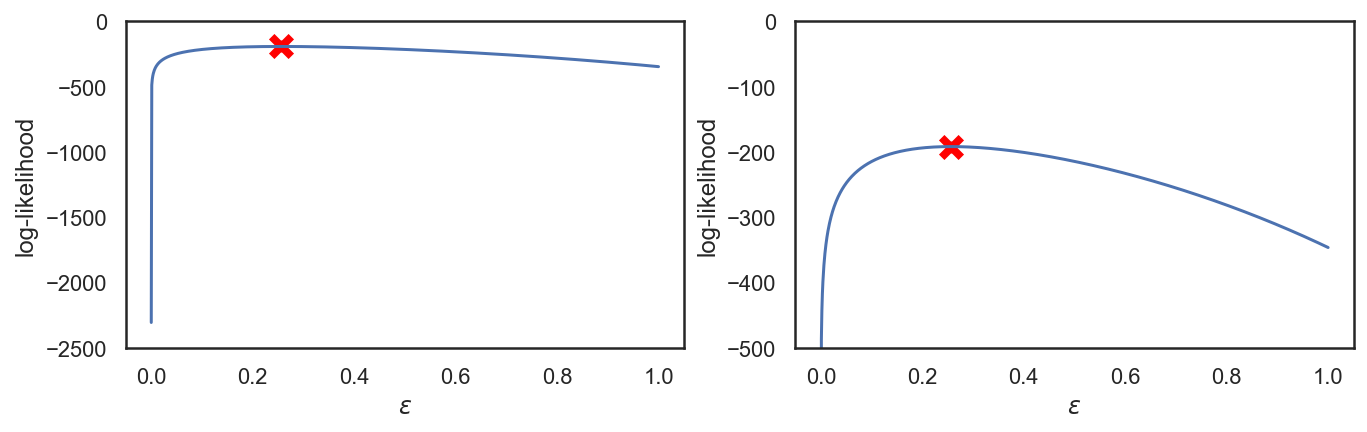

In [13]:
fig, axs = plt.subplots(1,2,figsize=(11,3))

for i in range(2):
    sns.lineplot(x=r"$\epsilon$", y="log-likelihood", data=ll_df, ax=axs[i])

    sns.scatterplot(x = [best_param_manual], y = [best_value_manual], ax = axs[i], color = "red", \
                    marker = 'X', s = 200)

axs[0].set_ylim(-2500,0)
axs[1].set_ylim(-500,0)

plt.show()

Note that this data was originally generated with $\epsilon \approx 0.3$, so the estimate is close to ground truth.

## Interpreting results

Recall that in the model description we noted that $\epsilon$ is a free parameter describing the probability to choose randomly instead of applying the "Win-Stay-Lose-Switch" rule. The model fitting results can be interpreted in the light of this information. That is, the probability that an individual will choose randomly is around 0.26 according to our estimate. Given the task is to choose between movies in a streaming platform, the user behavior can be interpreted as follows: at probability 0.26 the user will choose randomly, otherwise if they like a movie, they will choose it again - and if the hate it, switch.

<div class="alert alert-block alert-info">
<h4><img src="img/logo/goal.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Checkpoint</h4> 
What kind of a result does the model fitting presented in this notebook yield?
<br>a) A probability distribution of the parameter of interest  
<br>b) A point estimate of the parameter of interest
<br>c) A point estimate of the parameter of interest with a quantification of uncertainty of this measure
</div>

# Making predictions

## Simulating user behaviour

A benefit of a computational model of user behavior is that it is easy to simulate behaviors using this model, which is demonstrated below (in code and with a plot).

In [14]:
def run_simulation(model, param):

    # Create the agent
    agent = model(*param)

    # Data containers
    choices = np.zeros(T, dtype=int)
    successes = np.zeros(T, dtype=bool)

    # Simulate the task
    for t in range(T):

        # Determine choice
        choice = agent.choose()

        # Determine success
        success = P[choice] > np.random.random()

        # Make agent learn
        agent.learning_rule(option=choice, success=success)

        # Backup
        choices[t] = choice
        successes[t] = success

    return pd.DataFrame({
        "time": np.arange(T),
        "choice": choices, 
        "success": successes})


# Seed the pseudo-random number generator
np.random.seed(0)

# We will experiment with Win-Stay Lose-Switch
model = WSLS

# Get data
param_single = np.array([0.1])
bhv_single = run_simulation(model=model, param=param_single)

# Backup
bhv_single.to_csv(os.path.join(BKP_FOLDER, "bhv_single.csv"))

In [15]:
# Load the data
bhv_single = pd.read_csv(os.path.join(BKP_FOLDER, "bhv_single.csv"), 
                         index_col=[0])
# Print...
display(bhv_single)

,time,choice,success
0,0,1,True
1,1,1,True
2,2,1,True
3,3,1,False
4,4,1,True
...,...,...,...
495,495,0,True
496,496,0,False
497,497,1,True
498,498,1,False


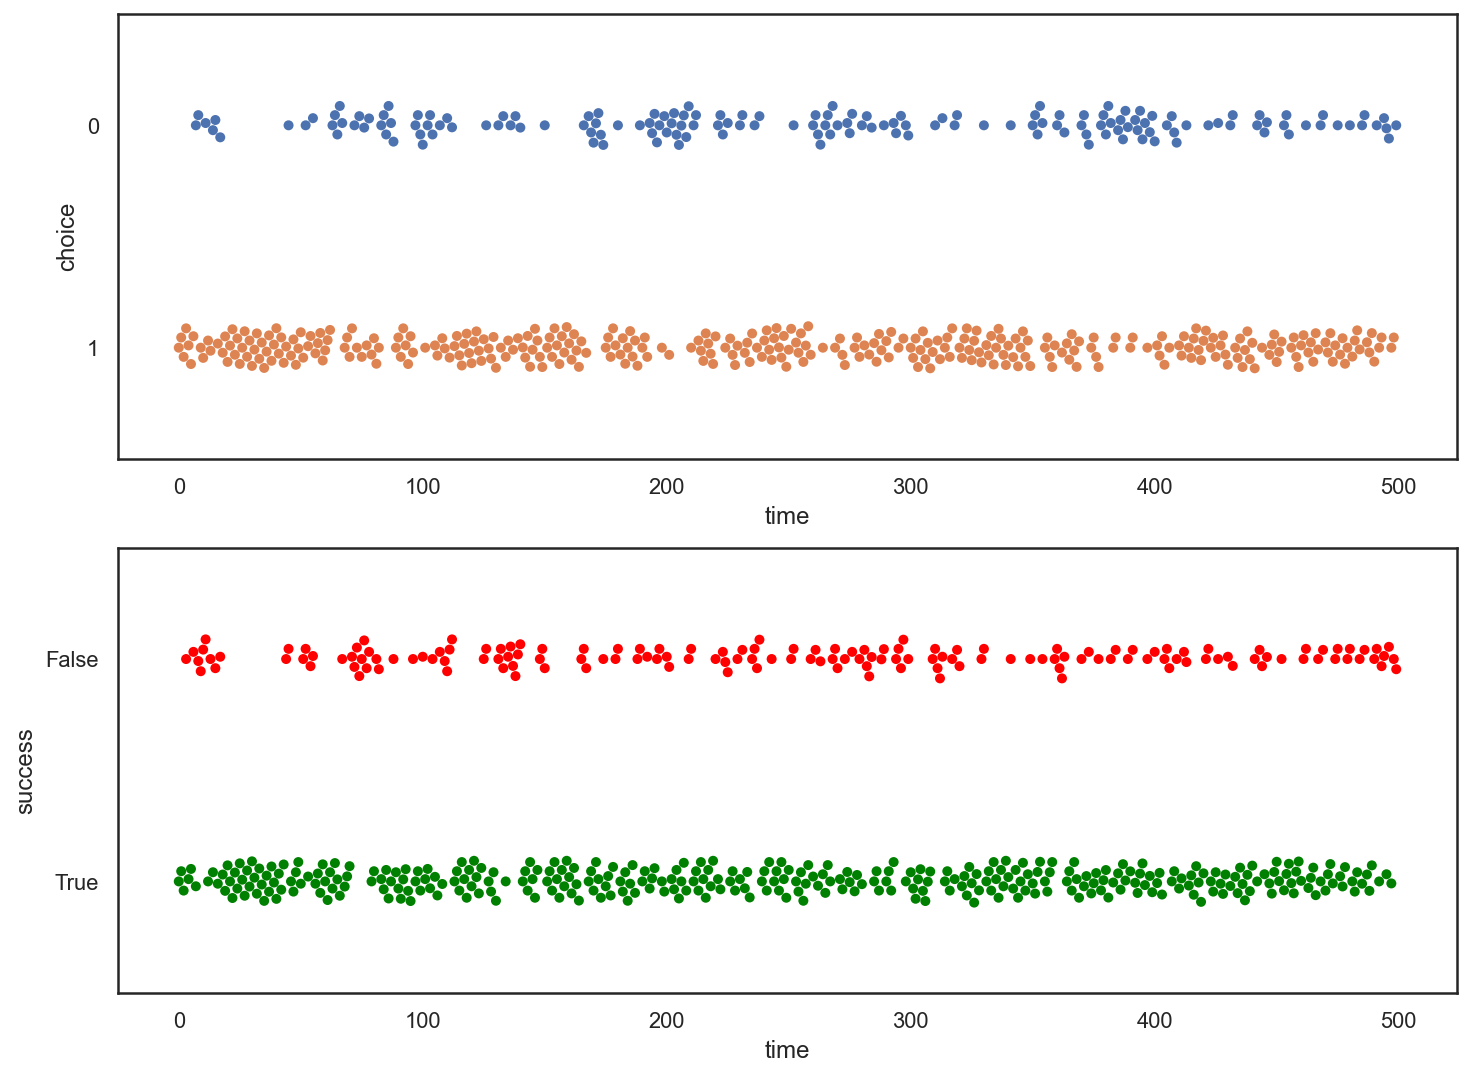

In [16]:
# Create figure and axes
fig, axes = plt.subplots(nrows=2, figsize=(12, 9))

# Show choices
sns.swarmplot(data=bhv_single, x='time', y='choice', ax=axes[0], orient="h")

# Show success
sns.swarmplot(data=bhv_single, x='time', y='success',
              ax=axes[1], palette={True: "green", False: "red"}, orient="h")

plt.show()

# Sanity checking a user model

<div class="alert alert-block alert-info">
<h4><img src="img/logo/goal.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Goal</h4> 
Be able to <b>conduct a parameter recovery study</b> and explain why their results matter for the <b>interpretation of a user model</b>
</div>

After fitting a model to data, a necessary question that needs to be asked is: *How confident can we be in our estimate?* This section presents a technique called **parameter recovery**, which addresses this question.

## What is parameter recovery?

Parameter recovery is used in judging whether a given model and estimation technique provide accurate and consistent results when fitted to data (see, e.g., [Wilson & Collins (2019)](https://doi.org/10.7554/eLife.49547) or [Heathcote et al. (2015)](https://doi.org/10.1007/978-1-4939-2236-9_2)).

That is, consider data produced by a model with some parameters $\theta$. The same model is then fitted to this generated data to obtain inferred parameters $\hat{\theta}$. The generating parameters $\theta$ should be close to the inferred parameters $\hat{\theta}$. In our example case, this would mean the following: consider that there is an individual producing data with given value of $\epsilon$ in WSLS. We take the data that this individual has generated and fit WSLS to it. We should obtain a value of $\hat{\epsilon}$ that is close to the original one. If this is not the case, the parameters of the model do not recover.

Inadequate parameter recovery is a warning sign in modeling. It suggests that a given model specification or parameter inference technique might not be suitable for the given modeling task. 

This can be also understood by thinking about a case when parameter recovery has not been verified and the modeler directly proceeds to fitting the model to data. The modeler assumes that the chosen model is a good description of the underlying phenomenon and thus trusts that the inferred parameters are accurate. However, since the ground truth parameters are unknown, there is no way of verifying the accuracy of the inferred parameters. Here parameter recovery can help. By considering data generated by known parameters, we can assess whether it is theoretically possible to recover the parameters and obtain consistent results.

As a caveat, even though unsuccessful parameter recovery is a warning sign suggesting that the given model should not be fitted to data with the chosen inference technique, good parameter recovery does not guarantee that results are reliable. However, they can increase our confidence in the inference results.

### Running a parameter recovery simulation

In this section we run a simple parameter recovery simulation.

<img src="img/parameter-recovery-illustration.jpg" width="600">
<em>Parameter recovery simulation conceptually and in code.</em>

In [17]:
# Seed the pseudo-random number generator
np.random.seed(1284)

# Select one model
model = WSLS 

# Define the number of agents to simulate
n = 30 

# Data container
row_list = []

# For each agent...
for i in tqdm(range(n), file=sys.stdout):

    # Generate parameters to simualte
    param_to_sim = [np.random.uniform(*b)
                    for b in model.fit_bounds]

    # Simulate
    d = run_simulation(model=model, param=param_to_sim)

    # Optimize
    best_param, best_value = optimize(model=model, data=d)

    # Backup
    for j in range(len(param_to_sim)):
        row_list.append({
            "Parameter": model.param_labels[j],
            "Used to simulate": param_to_sim[j],
            "Recovered": best_param[j]})

# Create dataframe and save it
df = pd.DataFrame(row_list)
df.to_csv(os.path.join(BKP_FOLDER, "likelihood_explo.csv"))

100%|███████████████████████████████████████████| 30/30 [00:09<00:00,  3.08it/s]


In [18]:
# Load the dataframe and display it
df = pd.read_csv(os.path.join(BKP_FOLDER, "likelihood_explo.csv"), index_col=[0])
display(df.head())

,Parameter,Used to simulate,Recovered
0,epsilon,0.774765,0.721443
1,epsilon,0.739455,0.789579
2,epsilon,0.062072,0.060120
3,epsilon,0.129357,0.148297
4,epsilon,0.059156,0.060120


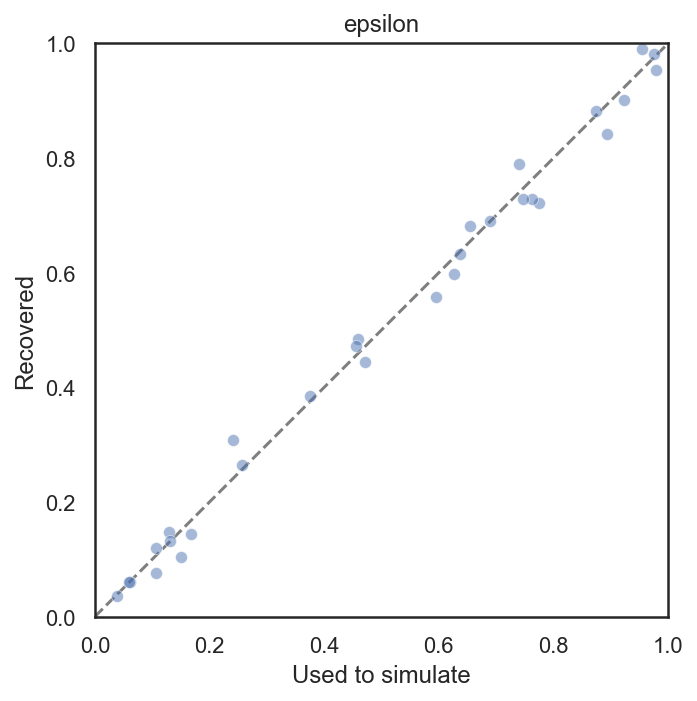

In [19]:
# Plot
param_names=WSLS.param_labels
param_bounds=WSLS.fit_bounds
n_param = len(param_names)

# Define colors
colors = [f'C{i}' for i in range(n_param)]

# Create fig and axes
fig, axes = plt.subplots(ncols=n_param,
                         figsize=(5, 5))

for i in range(n_param):

    # Select ax
    if n_param > 1:
        ax = axes[i]
    else:
        ax = axes
    
    # Get param name
    p_name = param_names[i]
    
    # Set title
    ax.set_title(p_name)

    # Create scatter
    sns.scatterplot(data=df[df["Parameter"] == p_name], 
                    x="Used to simulate", y="Recovered", 
                    alpha=0.5, color=colors[i], 
                    ax=ax)

    # Plot identity function
    ax.plot(param_bounds[i], param_bounds[i], 
            linestyle="--", alpha=0.5, color="black", zorder=-10)
    
    # Set axes limits
    ax.set_xlim(*param_bounds[i])
    ax.set_ylim(*param_bounds[i])

    # Square aspect
    ax.set_aspect(1)

plt.tight_layout()
plt.show()

### Interpreting results

The plot given above gives us a rough idea of how well the parameters recover. That is, if parameter recovery is sufficient, the points should lie along the line of equality ($x=y$). For a more systematic analysis, calculating some indicator of the correlation between generating and inferred parameters is necessary (e.g., the Pearson correlation coefficient).

## Other sanity checks

In addition to parameter recovery, some sensible checks are presented in Wilson & Collins (2019). For instance, it is sensible to:

- Simulate the candidate model across range of parameter values
- Visualize simulated behavior of different candidate models
- Run a model comparison
- Make predictions with the candidate model

But note that this list is not comprehensive and the work of a modeler is never complete!

<div class="alert alert-block alert-info">
<h4><img src="img/logo/goal.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Checkpoint</h4> 
Which of these statements is true (one or more):   
<br>a) If parameter recovery is insufficient, a model or the task needs to be reconstructed
<br>b) If parameter recovery is sufficient, we can be fairly confident in our inference results  
<br>c) Parameter recovery should always be verified before fitting a model to data
</div>

# Summary

In this lecture, we have:

- Looked at what **user models** are, as well as named some examples of user models and their **application contexts**.
- Built understanding of the basic principles of **designing a user model** that describes **some phenomenon** taking place in **a given task**.
- **Fitted a model** to some data.
- Conducted a **parameter recovery study** and explained why its results matter for the **interpretation of a user model**.

# References

P. De Bra, "Challenges in User Modeling and Personalization," in IEEE Intelligent Systems, vol. 32, no. 5, pp. 76-80, September/October 2017, https://doi.org/10.1109/MIS.2017.3711638.

Brusilovsky, P. Methods and techniques of adaptive hypermedia. User Model User-Adap Inter 6, 87–129 (1996). https://doi.org/10.1007/BF00143964

Fischer, G. User Modeling in Human–Computer Interaction. User Modeling and User-Adapted Interaction 11, 65–86 (2001). https://doi.org/10.1023/A:1011145532042

Heathcote A., Brown S., Wagenmakers EJ. (2015) An Introduction to Good Practices in Cognitive Modeling. In: Forstmann B., Wagenmakers EJ. (eds) An Introduction to Model-Based Cognitive Neuroscience. Springer, New York, NY. https://doi.org/10.1007/978-1-4939-2236-9_2

Knutov, E. (2012). Generic adaptation framework for unifying adaptive web-based systems. Technische Universiteit Eindhoven. https://doi.org/10.6100/IR732111

Kobsa, A. Generic User Modeling Systems. User Modeling and User-Adapted Interaction 11, 49–63 (2001). https://doi.org/10.1023/A:1011187500863

Rich, E. (1979). User modeling via stereotypes*. Cognitive Science, 3(4), 329–354. https://doi.org/10.1207/s15516709cog0304_3

Webb, G.I., Pazzani, M.J. & Billsus, D. Machine Learning for User Modeling. User Modeling and User-Adapted Interaction 11, 19–29 (2001). https://doi.org/10.1023/A:1011117102175

Wilson RC, Collins AG. Ten simple rules for the computational modeling of behavioral data. Elife. 2019 Nov 26;8:e49547. https://doi.org/10.7554/eLife.49547. PMID: 31769410; PMCID: PMC6879303.

# Additional material

A more comprehensive account of the techniques introduced in this lecture are available in previous year's lecture materials by Aurélien Nioche (available [here](https://github.com/AurelienNioche/LectureUserResearch/blob/master/OLD_lecture10.ipynb) and in [Wilson & Collins (2019)](https://doi.org/10.7554/eLife.49547).

## Probabilistic inference

In [50]:
def model(choices, successes):
    
    # Sample epsilon
    epsilon = pyro.sample("epsilon", dist.Uniform(0, 1))
    
    p_apply_rule = 1 - epsilon # 1 - epsilon: apply the rule
    p_random = epsilon / N # epsilon: pick up randomly
    
    p_stay_if_success = p_random + p_apply_rule
    p_alternative_if_failure = p_apply_rule / (N - 1) + p_random

    # Data container
    tensor_p_one = torch.zeros(T)

    # Simulate the task
    for t in range(T):

        if t == 0:
            p_one = 1/N  # First turn
        else:
            # Get choice and success for t -1
            previous_c, previous_s = choices[t-1], successes[t-1]
            
            # Previous choice was 1 and was a success
            if previous_c == 1 and previous_s:
                p_one = p_stay_if_success
            
            # If previous choice was NOT 1 and was NOT a success 
            elif previous_c != 1 and not previous_s:
                p_one = p_alternative_if_failure
                
            # Otherwise
            else:
                p_one = p_random
                    
        tensor_p_one[t] = p_one

    with pyro.plate("plate"):
        pyro.sample("log_gdp", dist.Bernoulli(probs=tensor_p_one), obs=choices)

In [51]:
# Load the data
wsls_data = pd.read_csv(os.path.join(DATA_FOLDER, "wsls-data.csv"), 
                         index_col=[0])
# Print...
display(wsls_data)

,time,choice,success
0,0,1,True
1,1,1,True
2,2,1,True
3,3,1,False
4,4,1,True
...,...,...,...
495,495,0,True
496,496,0,False
497,497,1,True
498,498,1,False


In [52]:
choices = torch.from_numpy(wsls_data.choice.values).float()
successes = torch.from_numpy(wsls_data.success.values)
        
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=1000, num_chains=1)
mcmc.run(choices=choices, successes=successes)

Sample: 100%|██████████| 2000/2000 [01:28, 22.70it/s, step size=7.88e-01, acc. prob=0.945]


In [53]:
mcmc.summary(prob=.95)


                mean       std    median      2.5%     97.5%     n_eff     r_hat
   epsilon      0.26      0.03      0.26      0.20      0.31    480.16      1.00

Number of divergences: 0


In [54]:
mcmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

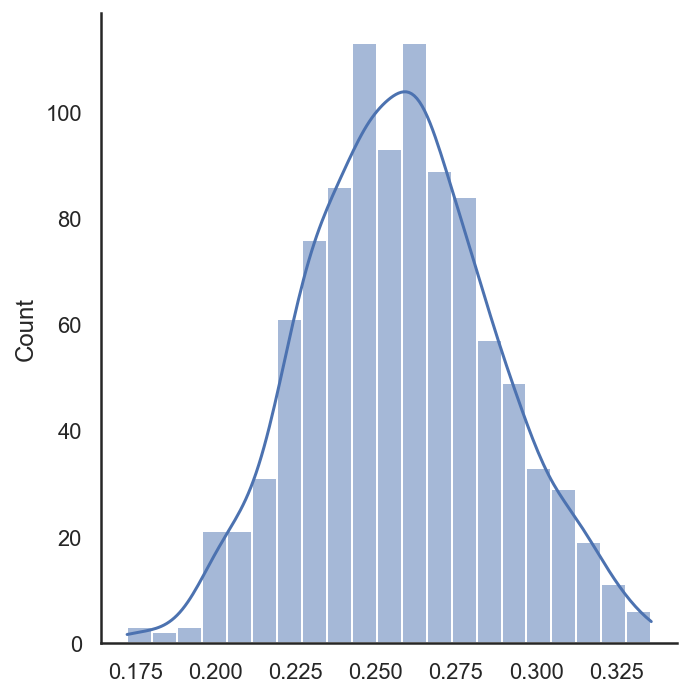

In [55]:
sns.displot(mcmc_samples['epsilon'], kde=True);